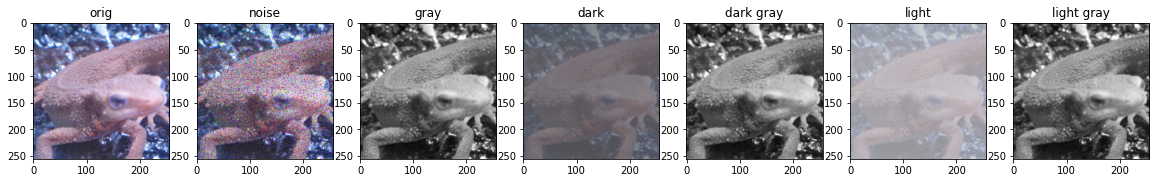

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256.png')
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_noise.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_light.png')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(20, 4))
plt.subplot(1, 7, 1); plt.imshow(img_orig); plt.title('orig')
plt.subplot(1, 7, 2); plt.imshow(img_noise); plt.title('noise')
plt.subplot(1, 7, 3); plt.imshow(img_gray, cmap='gray'); plt.title('gray')
plt.subplot(1, 7, 4); plt.imshow(img_dark);  plt.title('dark')
plt.subplot(1, 7, 5); plt.imshow(img_dark_gray, cmap='gray'); plt.title('dark gray')
plt.subplot(1, 7, 6); plt.imshow(img_light);  plt.title('light')
plt.subplot(1, 7, 7); plt.imshow(img_light_gray, cmap='gray'); plt.title('light gray')
plt.show()

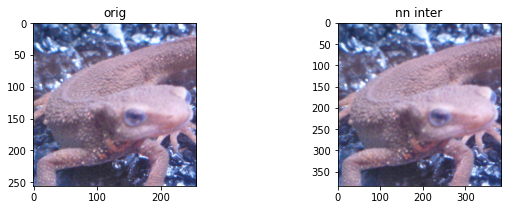

In [2]:
# Q.26. バイリニア補間, Bi-linear interpolation
# Bi-linear補間により画像を1.5倍に拡大させる
# Bi-linear補間とは周辺の４画素に距離に応じた重みをつけることで補完する手法

# opencv
img_nn = cv2.resize(img_orig, (int(img_orig.shape[1] * 1.5), int(img_orig.shape[0] * 1.5)),
                    interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1); plt.imshow(img_orig); plt.title('orig')
plt.subplot(1, 2, 2); plt.imshow(img_nn); plt.title('nn inter')
plt.show()

In [21]:
def bilinear_inter(img, a, b):
    h, w, c = img.shape
    out_h = int(h * a)
    out_w = int(w * b)
    
    xs, ys = np.meshgrid(range(out_w), range(out_h))
    
    _xs = np.floor(xs / b).astype(int)
    _ys = np.floor(ys / a).astype(int)
    
    dx = xs/b - _xs
    dy = ys/a - _ys
    
    # -1を指定することで最後の次元に突っ込める、または作成できる
    dx = np.repeat(np.expand_dims(dx, axis=-1), c, axis = -1)
    dy = np.repeat(np.expand_dims(dy, axis=-1), c, axis = -1)
    
    # 元画像からはみ出さないように！！
    _xs1p = np.minimum(_xs + 1, w - 1)
    _ys1p = np.minimum(_ys + 1, h - 1)
    
    out = (1 - dx) * (1 - dy) * img[_ys, _xs] + (dx) * (1 - dy) * img[_ys, _xs1p] + (1 - dx)*(dy) * img[_ys1p, _xs] + dx*dy*img[_ys1p, _xs1p]
    
    return np.clip(out, 0, 255).astype(np.uint8)

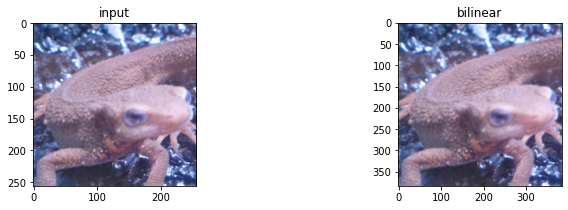

In [22]:
img_bl = bilinear_inter(img_orig, a = 1.5, b=1.5)
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('bilinear')
plt.imshow(img_bl)
plt.show();

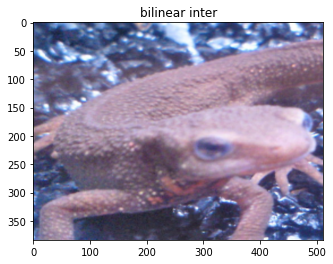

In [23]:
img_bl = bilinear_inter(img_orig, a=1.5, b=2)
plt.imshow(img_bl); plt.title('bilinear inter'); plt.show()

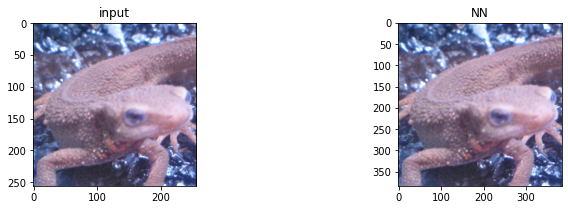

In [28]:
# Q.27. Bi-cubic補間
# Bi-cubic補間により画像を1.5倍に拡大させる
# Bi-cubic補間とはBi-linear補間の拡張であり、周辺の16画素から補間

# opencv
# resizeの指定はタプルで行う
img_nn = cv2.resize(img_orig, (int(img_orig.shape[0]*1.5), int(img_orig.shape[1]*1.5)), 
                   interpolation = cv2.INTER_CUBIC)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('NN')
plt.imshow(img_nn)
plt.show();

In [42]:
def bicubic_inter(img, a, b):
    h, w, c = img.shape
    out_h = int(h * a)
    out_w = int(w * b)
    out = np.zeros([out_h, out_w, c], dtype = np.float32)
    
    xs, ys = np.meshgrid(range(out_w), range(out_h))
    
    # _xs, _ysは元の画像のサイズ
    _xs = np.floor(xs/b).astype(int)
    _ys = np.floor(ys/a).astype(int)
    
    dx1 = np.abs(xs/b - (_xs - 1))
    dx2 = np.abs(xs/b - (_xs))
    dx3 = np.abs(xs/b - (_xs + 1))
    dx4 = np.abs(xs/b - (_xs + 2))
    dy1 = np.abs(ys/a - (_ys - 1))
    dy2 = np.abs(ys/a - (_ys))
    dy3 = np.abs(ys/a - (_ys + 1))
    dy4 = np.abs(ys/a - (_ys + 2))

    dxs = [dx1, dx2 ,dx3, dx4]
    dys = [dy1, dy2 ,dy3, dy4]
    
    def weight(t, a = -1):
        w = np.zeros_like(t)
        w[t <= 1] = ((a + 2) * (t ** 3) - (a + 3) * (t **2 )+ 1)[t<=1]
        w[t > 1] = ((a * t ** 3) - 5 * a * t** 2 + 8* a * t - 4 * a)[t > 1]
        return w
    
    w_sum = np.zeros_like(out, dtype=np.float32)
    
    # 距離がx - 1からx + 2までの距離だから。yも同様
    for j in range(-1, 3):
        for i in range(-1, 3):
            ind_x = np.minimum(np.maximum(_xs + i, 0), w-1)
            ind_y = np.minimum(np.maximum(_ys + j, 0), h-1)
            
            wx = weight(dxs[i+1])
            wy = weight(dys[j+1])
            wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis = -1)
            wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis = -1)
            
            w_sum += wx * wy
            out += wx * wy * img[ind_y, ind_x]
            
    return np.clip(out/w_sum, 0, 255).astype(np.uint8)


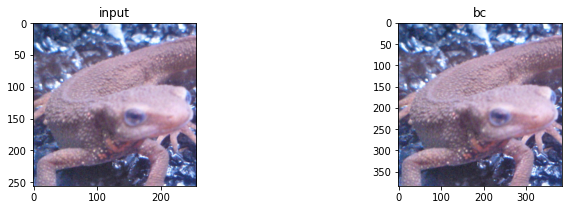

In [43]:
img_bc = bicubic_inter(img_orig, a = 1.5, b=1.5)
plt.figure(figsize=(12, 3))
plt.subplot(1,2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1,2, 2)
plt.title('bc')
plt.imshow(img_bc)
plt.show();

In [44]:
np.meshgrid(range(5), range(10))

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9]])]

In [45]:
# meshgrid sample
tmp = np.zeros([15, 15])
tmp[np.meshgrid(range(5), range(10))] = 1
tmp

<ipython-input-45-95c377a715f3>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tmp[np.meshgrid(range(5), range(10))] = 1


array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

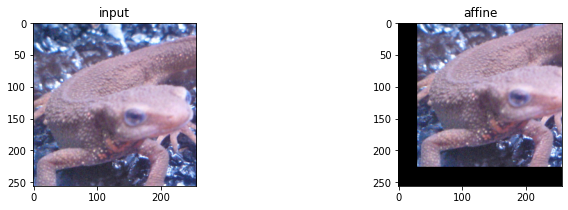

In [46]:
# Q.28. アフィン変換(平行移動), Affine shift
# アフィン変換を利用して画像をx方向に+30、y方向に-30だけ平行移動させる
# アフィン変換とは3x3の行列を用いて画像の変換を行う操作

# opencv
h, w, c = img_orig.shape
img_affine_shift = cv2.warpAffine(img_orig, np.array([[1, 0, 30], [0, 1, -30]], dtype=np.float32), (h, w))

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('affine')
plt.imshow(img_affine_shift)
plt.show();


In [51]:
def affine(img, affine_mat, out_shape):
    h, w, channel = img.shape
    
    [a, b, tx], [c, d, ty] = affine_mat
    out_h, out_w = out_shape
    
    out = np.zeros([out_h, out_w, channel])
    
    # 平行移動後、塗りつぶすところをpadする
    img_pad = np.pad(img, [(1, 1), (1, 1), (0, 0)])
    
    xs, ys = np.meshgrid(range(out_w), range(out_h))

    # 行列式を利用して元の画像ピクセルの位置を拡大後の画像ピクセルの位置から逆算する
    _xs = np.maximum(np.minimum((1 / (a * d - b * c) * (d * xs -  b * ys) - tx).astype(int) + 1, w + 1), 0)
    _ys = np.maximum(np.minimum((1 / (a * d - b * c) * (-c * xs + a * ys) - ty).astype(int) + 1, h + 1), 0)
    
    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

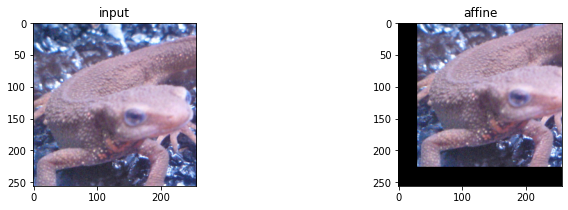

In [52]:
h, w, c = img_orig.shape
img_affine_shift = affine(img_orig, [[1, 0, 30], [0, 1, -30]], (h, w))

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('affine')
plt.imshow(img_affine_shift)
plt.show()

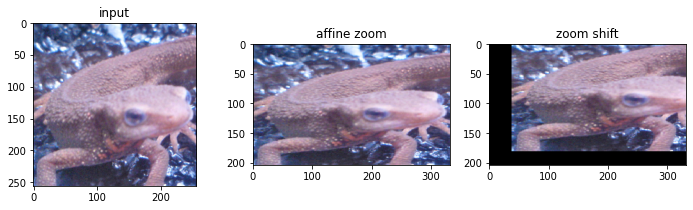

In [64]:
# Q.29. アフィン変換(拡大縮小), Affine scale
# アフィン変換を用いて、(1)x方向に1.3倍、y方向に0.8倍にリサイズ
h, w, c = img_orig.shape
img_affile_zoom = affine(img_orig, [[1.3, 0, 0], [0, 0.8, 0]], (int(h*0.8), int(w*1.3)))
img_affine_zoom_shift = affine(img_orig, [[1.3, 0, 30], [0, 0.8, -30]], (int(h * 0.8), int(w *1.3)))

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.title('affine zoom')
plt.imshow(img_affile_zoom)
plt.subplot(1, 3, 3)
plt.title('zoom shift')
plt.imshow(img_affine_zoom_shift)
plt.show()

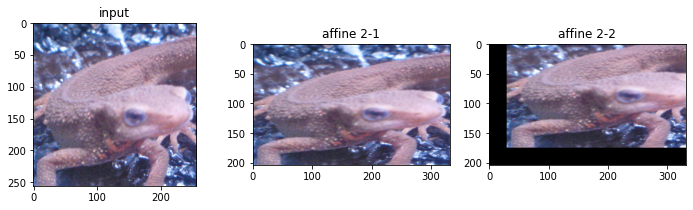

In [55]:
# opencv
h, w, c = img_orig.shape
img_affine_2_1 = cv2.warpAffine(img_orig, np.array([[1.3, 0, 0], [0, 0.8, 0]], dtype=np.float32), (int(w * 1.3), int(h * 0.8)))
img_affine_2_2 = cv2.warpAffine(img_orig, np.array([[1.3, 0, 30], [0, 0.8, -30]], dtype=np.float32), (int(w * 1.3), int(h * 0.8)))

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.title('affine 2-1')
plt.imshow(img_affine_2_1)
plt.subplot(1, 3, 3)
plt.title('affine 2-2')
plt.imshow(img_affine_2_2)
plt.show();

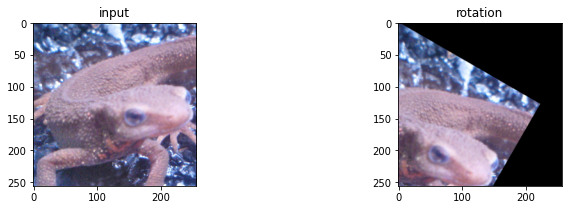

In [77]:
# Q.30. アフィン変換(回転), Affine rotation
# (1)アフィン変換を用いて、反時計方向に30度回転させる。
# (2) アフィン変換を用いて、反時計方向に30度回転した画像で中心座標を固定することで、
# なるべく黒い領域がなくなるように画像を作成する

# opencv
h, w, c = img_orig.shape
# cv2.getRotationMatrix2Dの引数は((シフトさせる座標差(回転の支点)), 回転度数, 拡大縮小)
img_affine_rota = cv2.warpAffine(img_orig, cv2.getRotationMatrix2D((0, 0), -30, scale=1.0), (h, w))

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1,2, 2)
plt.title('rotation')
plt.imshow(img_affine_rota)
plt.show()

In [78]:
cv2.getRotationMatrix2D((0,0), -30, 1.0)

array([[ 0.8660254, -0.5      ,  0.       ],
       [ 0.5      ,  0.8660254,  0.       ]])

In [79]:
cv2.getRotationMatrix2D((w/2.0, h/2.0), -30, 1.0)

array([[  0.8660254 ,  -0.5       ,  81.14874832],
       [  0.5       ,   0.8660254 , -46.85125168]])

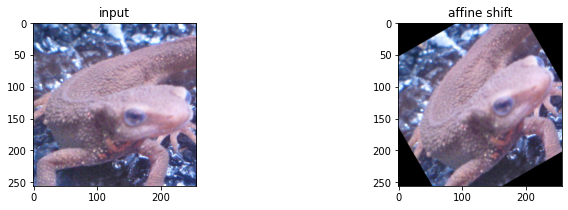

In [80]:
# opencv considering shift
h, w, c = img_orig.shape
img_affine_shift = cv2.warpAffine(img_orig, cv2.getRotationMatrix2D((w / 2, h / 2), 30, 1.0), (h, w))

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1); plt.title('input'); plt.imshow(img_orig)
plt.subplot(1, 2, 2); plt.title('affine shift'); plt.imshow(img_affine_shift)
plt.show()

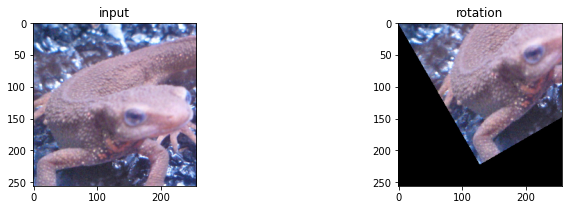

In [85]:
rad = -30 / 180 *np.pi
h, w, c = img_orig.shape

img_affine_rotation = affine(img_orig, [[np.cos(rad), - np.sin(rad), 0], [np.sin(rad), np.cos(rad), 0]], (h, w))

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1,2, 2)
plt.title('rotation')
plt.imshow(img_affine_rotation)
plt.show();

80.29749663118369


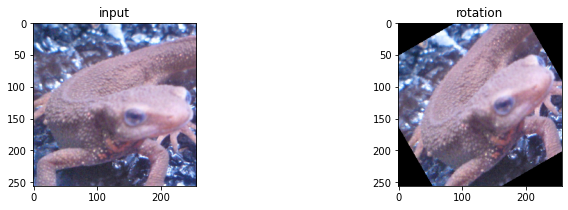

In [106]:
rad = -30 / 180 *np.pi
h, w, c = img_orig.shape

# 図を書いたら何をしているかわかる
# tx = int((np.cos(-rad) - 1) * w // 2 - np.sin(-rad) * h //2)
# ty = int(np.sin(-rad) * w // 2 + (np.cos(-rad)-1) * h //2)
tx = ((np.sin(-rad) * w) - (h - (np.cos(-rad) * h)))//2 + (h - (np.cos(-rad) * h))
ty = (np.sin(-rad) * h - (w - np.cos(-rad) * w)) //2
img_affine_rotation = affine(img_orig, [[np.cos(rad), - np.sin(rad), -tx], [np.sin(rad), np.cos(rad), ty]], (h, w))

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1,2, 2)
plt.title('rotation')
plt.imshow(img_affine_rotation)
plt.show();